<a href="https://colab.research.google.com/github/Shreyas911/PINN/blob/main/PINN_Mountain_glacier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics Informed Neural Networks for the Mountain glacier model

## Install the required libraries

We first import all the required libraries. In order to use PyTorch with TPUs, we have to install the TPU client using pip.

Note that the pip install command might change based on the version that is currently in use. 

In [1]:
#!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchtext==0.10.0 -f https://download.pytorch.org/whl/cu111/torch_stable.html

### Import the required libraries
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_xla ## Specially for TPUs
import torch_xla.core.xla_model as xm ## Specially for TPUs

     |████████████████████████████████| 149.9 MB 33 kB/s 
     |████████████████████████████████| 57 kB 2.7 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.290 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.
Looking in links: https://download.pytorch.org/whl/cu111/torch_stable.html
     |█████████████                   | 834.1 MB 1.5 MB/s eta 0:13:46tcmalloc: large alloc 1147494400 bytes == 0x55f0b9d06000 @  0x7fe2359e1615 0x55f080be34cc 0x55f080cc347a 0x55f080be62ed 0x55f080cd7e1d 0x55f080c59e99 0x55f080c549ee 0x55f080be7bda 0x55f080c59d00 0x55f080

In [2]:
## Specify the device

We now specify the device type. There are two options to leverge the power of parallel computing. We can either use GPUs or TPUs. In this case, we use TPUs. 

SyntaxError: ignored

In [3]:
### GPU ###
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#torch.cuda.empty_cache()
###########

### TPU ###
device = xm.xla_device()
###########

device

device(type='xla', index=1)

We now define a class of neural networks which inherits from the *nn.Module* class. It's a 5 layer Artificial Neural Network (ANN). We make use of the tanh activation function. This allows the model to learn highly non-linear relationships.

In [4]:
class physics_informed_NN(nn.Module):
    
    def __init__ (self):

        super(physics_informed_NN, self).__init__()

        self.fc1 = nn.Linear(2, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 200)
        self.fc4 = nn.Linear(200, 200)
        self.fc5 = nn.Linear(200, 200)
        self.fc6 = nn.Linear(200, 200)
        self.fc7 = nn.Linear(200, 200)
        self.fc8 = nn.Linear(200, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = torch.tanh(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = torch.tanh(self.fc7(x))
        x = self.fc8(x)
        return x

physics_informed_NN

__main__.physics_informed_NN

##True solution 

We now generate the true solution for a simple mountain glacier model, taken from *Fundamentals of Glacier Dynamics* by CJ van der Veen and then look to make our neural network model *emulate* this PDE. The system is modeled by a non-linear, highly diffusive PDE. Although, ice sheet models tend to be non-local, but as a starting point we assume a local model. 

$$
 \frac{\partial H}{\partial t } = -\frac{\partial}{\partial x}\left(-D(x)\frac{\partial h}{\partial x}\right) + M\\
  D(x) = CH^{n+2}\left|\frac{\partial h}{\partial x}\right|^{n-1}\\
  C = \frac{2A}{n+2}(\rho g)^n\\
    H(x,t) = h(x,t) - b(x) \\ 
    H_l = 0, H_r > 0
$$

$$\frac{\partial{b}}{\partial{x}} = -0.1\\
M(x) = M_0 - x M_1 \:\text{(accumulation rate, essentially a source term)}\\
M_0 = 4.0 \:\text{m/yr}, \:M_1 = 0.0002 \:\text{yr}^{-1}\\
\rho = 920 \:\text{kg/m}^3\\
g = 9.8 \:\text{m/s}^2\\
A = 10^{-16} \: \text{Pa}^{-3} \text{a}^{-1}\\
n = 3\\
dx = 1.0 \:\text{km}, \:L = 30 \:\text{km}\\
dt = 1 \:\text{month}, \:T = 2000 \:\text{yr}$$

The true solution will be generated using a staggered grid finite volume method on a fine, uniform grid.



In [5]:
def accum_rate_func(x):
  M = 0.004-0.0002*x
  return M

def basal_topology_func(x):
  b = 1.0 - 0.01*x
  return b

def true_solution(L, T, accum_rate_func, basal_topology_func):

    dx = 1.0
    dt = 1./12.
    nx = int(L/dx)
    nt = int(T/dt)
    x = np.linspace(0,L,nx+1)
    t = np.linspace(0,T,nt+1)

    M = accum_rate_func(x)
    b = basal_topology_func(x)

    A = 1e-16
    rho = 920.0
    g = 9.2 
    n = 3

    C = 2*A/(n+2) * (rho*g)**n * (1e3)**n

    print(f"True value of C = {C}")

    h = np.zeros((nx+1,nt+1))
    H = np.zeros((nx+1,nt+1))
    h[:,0] = b
    h[0,:] = b[0]
    h[-1,:] = b[-1]

    H[:,0] = h[:,0] - b
    H[0,:] = h[0,:] - b[0]
    H[-1,:] = h[-1,:] - b[-1]

    for i in range(1,len(t)):

        D = C *((H[1:,i-1]+H[:nx,i-1])/2.0)**(n+2) * ((h[1:,i-1] - h[:nx,i-1])/dx)**(n-1)

        phi = -D*(h[1:,i-1]-h[:nx,i-1])/dx

        h[1:nx,i] = h[1:nx,i-1] + M[1:nx]*dt - dt/dx * (phi[1:]-phi[:nx-1])
        h[1:nx,i] = (h[1:nx,i] < b[1:nx]) * b[1:nx] + (h[1:nx,i] >= b[1:nx]) * h[1:nx,i]
        H[:,i] = h[:,i] - b

    return x, t, H, h, C, n


Here is the contourf plot for the true solution.

In [6]:
L = 30.
T = 2000.

x, t, H_true, h_true, C_true, n_true = true_solution(L, T, accum_rate_func, basal_topology_func)

True value of C = 24254.200053759996


(31,) (24001,)


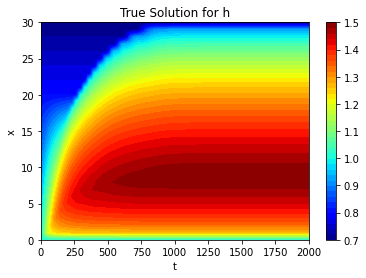

In [7]:
import matplotlib.colors as mcolors

print(x.shape, t.shape)
norm = mcolors.TwoSlopeNorm(vmin=-1, vmax = h_true.max(), vcenter=0)
plt.contourf(np.reshape(t, (-1)),np.reshape(x, (-1)),h_true, cmap = 'jet', levels = 50)
plt.xlabel('t')
plt.ylabel('x')
plt.title('True Solution for h')
plt.colorbar()

## How do we actually train our network?

Since we are training our network to emulate the PDE, we want to penalize the physics not being followed. We define the Loss function as follows (superscripts indicate the data) - 


$$\text{PDE operator} \quad \mathcal{F}(x, t) = H_t (x,t) - 3 (C H^5 h_x^3)_x  - M(x)$$
$$\text{Loss function} \quad \mathcal{L} = \frac{1}{N_i}\sum_{i=1}^{N_i} \left(h^i - h(x^i,0)\right)^2 + \frac{1}{N_b}\sum_{i=1}^{N_b} \left(h^i - h(x^i, t^i)\right)^2 + \frac{1}{N_c}\sum_{i=1}^{N_c} \left(\mathcal{F}(x^i, t^i) \right)^2 + \frac{1}{N_d}\sum_{i=1}^{N_d} \left(h^i - h(x^i, t^i)\right)^2$$

where, $N_i$, $N_b$, $N_c$ are the initial value points, boundary value points and collocation points in the interior where we want the model to obey the physics.

We only need to randomly sample the domain and boundaries to feed these points to the neural network. We will use $N_i = 50, N_b = 100, N_c = 20,000$ points to train the neural network, which is pretty sparse. The snippet below is to prepare the datasets.

In [8]:
x = x.reshape(-1,1)
t = t.reshape(-1,1)

### Initial data
Ni = 25
random_i = np.random.permutation(x.shape[0])[:Ni]
x_i = x[random_i]
t_i = np.zeros((Ni, 1))
h_i = np.reshape(h_true[random_i, 0], (-1,1))

### Boundary data
Nb = 1000
Nb = int(Nb/2) # Split points to two boundaries

random_b = np.random.permutation(t.shape[0])[:Nb]
x_l = np.zeros((Nb, 1))
x_r = L*np.ones((Nb, 1))
t_b = t[random_b]
h_l = np.reshape(h_true[0, random_b], (-1,1))
h_r = np.reshape(h_true[-1, random_b], (-1,1))

### Collocation points - sample such that you don't sample the boundary and initial points again
Nc = 140000

x_grid = np.tile(x,(1, t.shape[0]))
t_grid = np.tile(t.T,(x.shape[0], 1))

temp = np.zeros((x.shape[0]-2)*(t.shape[0]-1), dtype = bool)
temp[:Nc] = 1
temp = np.random.permutation(temp)
temp = np.reshape(temp, (x.shape[0]-2, t.shape[0]-1))
random_c = np.zeros((x.shape[0], t.shape[0]), dtype = bool)
random_c[1:-1,1:] = temp
x_c = x_grid[random_c].reshape(-1,1)
t_c = t_grid[random_c].reshape(-1,1)
h_c = h_true[random_c].reshape(-1,1)

### Data points - sample such that you don't sample the boundary and initial points again
Nd = 10000

temp = np.zeros((x.shape[0]-2)*(t.shape[0]-1), dtype = bool)
temp[:Nd] = 1
temp = np.random.permutation(temp)
temp = np.reshape(temp, (x.shape[0]-2, t.shape[0]-1))
random_d = np.zeros((x.shape[0], t.shape[0]), dtype = bool)
random_d[1:-1,1:] = temp
x_d = x_grid[random_d].reshape(-1,1)
t_d = t_grid[random_d].reshape(-1,1)
h_d = h_true[random_d].reshape(-1,1)

We plot the points we have sampled.

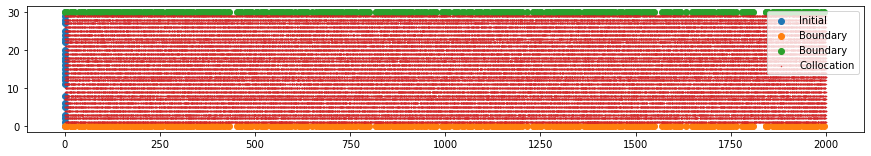

In [9]:
plt.figure(figsize = (15,15))
plt.gca().set_aspect(10)
plt.scatter(t_i, x_i, label = "Initial")
plt.scatter(t_b, x_l, label = "Boundary")
plt.scatter(t_b, x_r, label = "Boundary")
plt.scatter(t_c, x_c, label = "Collocation", s = 0.2)
plt.legend()

We have our data and we now convert it to torch tensors and concatenate the respective $x,t$ tensors to feed to the neural network.

In [10]:
x_torch_i = torch.from_numpy(x_i).float()
t_torch_i = torch.from_numpy(t_i).float()
h_torch_i = torch.from_numpy(h_i).float()

x_torch_l = torch.from_numpy(x_l).float()
x_torch_r = torch.from_numpy(x_r).float()
t_torch_b = torch.from_numpy(t_b).float()
h_torch_l = torch.from_numpy(h_l).float()
h_torch_r = torch.from_numpy(h_r).float()

x_torch_c = torch.from_numpy(x_c).float()
t_torch_c = torch.from_numpy(t_c).float()
h_torch_c = torch.from_numpy(h_c).float()

x_torch_d = torch.from_numpy(x_d).float()
t_torch_d = torch.from_numpy(t_d).float()
h_torch_d = torch.from_numpy(h_d).float()

### Concatenate the respective x and t tensors 
X_i = torch.cat((x_torch_i, t_torch_i), 1)

X_l = torch.cat((x_torch_l, t_torch_b), 1)
X_r = torch.cat((x_torch_r, t_torch_b), 1)

X_c = torch.cat((x_torch_c, t_torch_c), 1)

X_d = torch.cat((x_torch_d, t_torch_d), 1)

Now we transfer this data, as well as an object of the *physics_informed_NN* class to the TPUs to run our computatations.

In [11]:
PINN = physics_informed_NN()
PINN.to(device)

X_i = X_i.to(device)
H_small_i = h_torch_i.to(device)

X_l = X_l.to(device)
H_small_l = h_torch_l.to(device)
X_r = X_r.to(device)
H_small_r = h_torch_r.to(device)

X_c = X_c.to(device)
H_small_c = h_torch_c.to(device)

X_d = X_d.to(device)
H_small_d = h_torch_d.to(device)

Using the loss function defined above, we run backpropagation on the neural network using the *Adam* optimizer. Our criterion is obviously MSE Loss and we also have a scheduler to control the learning rate.

In [12]:
optimizer = torch.optim.Adam(PINN.parameters())
criterion = nn.MSELoss()
my_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=200, gamma=0.9)

The loop below is actually training the network. The epochs just mean the number of times the whole dataset is exposed to the neural network. Note that running on TPUs requires slightly different commands for optimizer steps.

In [13]:
statistics = []
for epochs in range(10000):

    X_c_clone = X_c.clone()
    X_c_clone.requires_grad = True
    h_pred = PINN(X_c_clone)

    b = 1.0 - 0.01*X_c_clone[:,0]
    b = torch.reshape(b, (-1,1))
    M = 0.004-0.0002*X_c_clone[:,0]

    H_pred = torch.sub(h_pred, b)
    gradients_h = torch.autograd.grad(torch.sum(h_pred), X_c_clone, create_graph=True)
    h_x = gradients_h[0][:,0]
    h_t = gradients_h[0][:,1]
    hessians_h = torch.autograd.grad(torch.sum(h_x), X_c_clone, create_graph=True)
    h_xx = hessians_h[0][:,0]

    gradients_H = torch.autograd.grad(torch.sum(H_pred), X_c_clone, create_graph=True)
    H_x = gradients_H[0][:,0]

    flux = - C_true * torch.pow(torch.squeeze(H_pred), 5) * torch.pow(torch.abs(h_x), 2) * h_x
    gradients_flux = torch.autograd.grad(torch.sum(flux), X_c_clone, create_graph=True)
    flux_x = - gradients_flux[0][:,0]
    pde_rhs = M + flux_x
    collocation_mse = criterion(h_t, pde_rhs)
    initial_mse = criterion(PINN(X_i), H_small_i)
    left_mse = criterion(PINN(X_l), H_small_l)
    right_mse = criterion(PINN(X_r), H_small_r)
    data_mse = criterion(PINN(X_d), H_small_d)

    loss = right_mse + left_mse + initial_mse + 100. * collocation_mse + 10. * data_mse
    optimizer.zero_grad()  
    loss.backward()     
    xm.optimizer_step(optimizer)
    xm.mark_step()
    my_lr_scheduler.step()

    if (epochs % 100 == 0):
        statistics.append([epochs, loss.cpu().data.numpy(), left_mse.cpu().data.numpy(), right_mse.cpu().data.numpy(), initial_mse.cpu().data.numpy(), collocation_mse.cpu().data.numpy(), data_mse.cpu().data.numpy()])
        print (f'epoch = {epochs}, loss = {loss}, left_loss = {left_mse}, right_loss = {right_mse}, initial_mse = {initial_mse}, collocation_mse = {collocation_mse}, data_mse = {data_mse}')
        # print (f'epoch = {epochs}, C = {C_true}, loss = {loss}, left_loss = {left_mse}, right_loss = {right_mse}, initial_mse = {initial_mse}, collocation_mse = {collocation_mse}')

epoch = 0, loss = 18.914695739746094, left_loss = 1.0398240089416504, right_loss = 0.5160378217697144, initial_mse = 0.7769637703895569, collocation_mse = 3.832145466731163e-06, data_mse = 1.6581487655639648
epoch = 100, loss = 0.33062899112701416, left_loss = 0.00750886183232069, right_loss = 0.07737177610397339, initial_mse = 0.0005466476432047784, collocation_mse = 1.300246367463842e-05, data_mse = 0.024390146136283875
epoch = 200, loss = 0.13036437332630157, left_loss = 0.016918981447815895, right_loss = 0.05071740224957466, initial_mse = 0.00028426424250938, collocation_mse = 6.088094596634619e-05, data_mse = 0.005635562818497419
epoch = 300, loss = 0.08978685736656189, left_loss = 0.0006759993848390877, right_loss = 0.01936519145965576, initial_mse = 7.348798681050539e-05, collocation_mse = 3.132819620077498e-05, data_mse = 0.006653936579823494
epoch = 400, loss = 0.05847618728876114, left_loss = 0.00797220878303051, right_loss = 0.0274064764380455, initial_mse = 0.00010827876394

We now check the performance of our model on the entire grid.

In [14]:
## Grid x,t together for test dataa
test_data = np.array(np.meshgrid(x, t))
test_data = np.moveaxis(test_data, [0, 1, 2], [-1,0,1])
input_test_data = torch.from_numpy(np.reshape(test_data, (-1, 2)))
input_test_data = input_test_data.to(device).float()

### Actual solution on the entire grid
h_test_data = torch.from_numpy(np.reshape(h_true, (-1,1)))

### Predict on the entire grid
with torch.no_grad():
##### FOR TPUs ######
    h_predicted = PINN(input_test_data).cpu().data.numpy()

##### FOR CUDA/GPUs ######
#   if torch.cuda.is_available():
#     h_predicted = PINN(input_test_data).cpu().data.numpy()
#   else:
#     h_predicted = PINN(input_test_data).data.numpy()


Now, we plot our predicted solution. Since *u_predicted* is a single vector, we need to reshaoe it into the shape of the grid in order to plot the filled contours. 

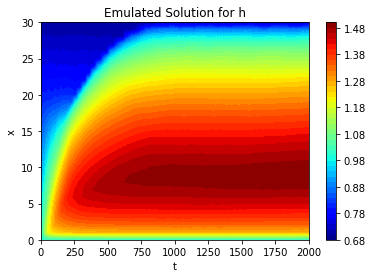

In [15]:
norm = mcolors.TwoSlopeNorm(vmin=-1, vmax = h_predicted.max(), vcenter=0)
h_pred_final = np.reshape(h_predicted, (h_true.shape[1], h_true.shape[0])).T

plt.contourf(np.squeeze(t),np.squeeze(x),h_pred_final, cmap = 'jet', levels = 50)
plt.xlabel('t')
plt.ylabel('x')
plt.title('Emulated Solution for h')
plt.colorbar()
plt.show()

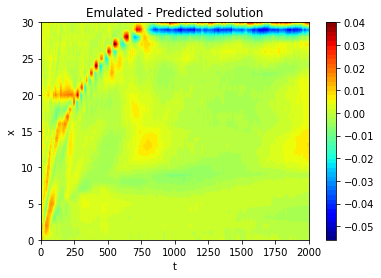

In [16]:
plt.contourf(np.squeeze(t),np.squeeze(x),(h_pred_final-h_true), cmap = 'jet', levels = 50)
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')
plt.title('Emulated - Predicted solution')
plt.show()

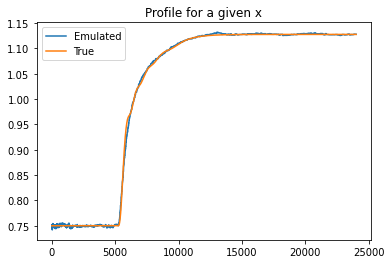

In [17]:
# plt.plot(h_pred_final)
plt.plot(h_pred_final[25,:], label = 'Emulated')
plt.plot(h_true[25,:], label = 'True')
plt.title('Profile for a given x')
plt.legend()

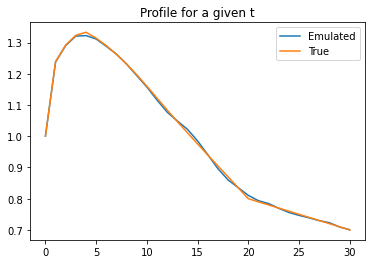

In [18]:
plt.plot(h_pred_final[:,1500], label = 'Emulated')
plt.plot(h_true[:,1500], label = 'True')
plt.title('Profile for a given t')
plt.legend()

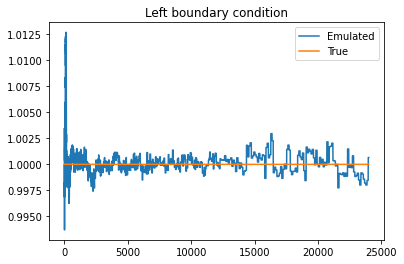

In [19]:
plt.plot(h_pred_final[0,:], label = 'Emulated')
plt.plot(h_true[0,:], label = 'True')
plt.title('Left boundary condition')
plt.legend()

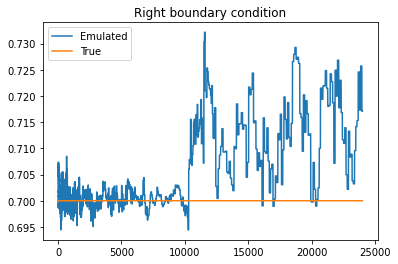

In [20]:
plt.plot(h_pred_final[-1,:], label = 'Emulated')
plt.plot(h_true[-1,:], label = 'True')
plt.title('Right boundary condition')
plt.legend()

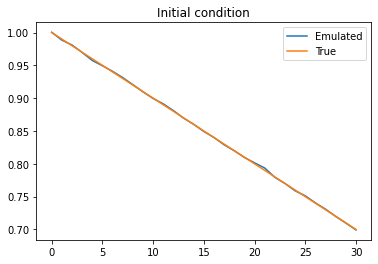

In [21]:
plt.plot(h_pred_final[:,0], label = 'Emulated')
plt.plot(h_true[:,0], label = 'True')
plt.title('Initial condition')
plt.legend()

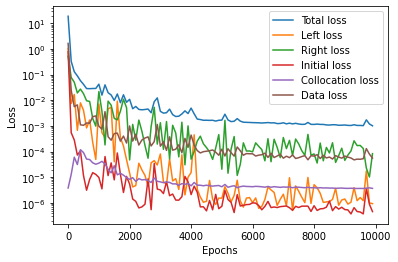

In [22]:
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot([statistic[0] for statistic in statistics], [statistic[1] for statistic in statistics], label = 'Total loss')
plt.plot([statistic[0] for statistic in statistics], [statistic[2] for statistic in statistics], label = 'Left loss')
plt.plot([statistic[0] for statistic in statistics], [statistic[3] for statistic in statistics], label = 'Right loss')
plt.plot([statistic[0] for statistic in statistics], [statistic[4] for statistic in statistics], label = 'Initial loss')
plt.plot([statistic[0] for statistic in statistics], [statistic[5] for statistic in statistics], label = 'Collocation loss')
plt.plot([statistic[0] for statistic in statistics], [statistic[6] for statistic in statistics], label = 'Data loss')
plt.legend()

## Inferring accumulation rate from data

Since we are training our network to find the diffusion coefficient, we want to enforce the physics, as well look to fit the data. We define the Loss function as follows (superscripts indicate the data) - 


$$\text{PDE operator} \quad \mathcal{F}(x, t) = H_t (x,t) - 3 (C H^5 h_x^3)_x  - M(x) $$
$$\text{Loss function} \quad \mathcal{L} = \frac{1}{N_i}\sum_{i=1}^{N_i} \left(h^i - h(x^i,0)\right)^2 + \frac{1}{N_b}\sum_{i=1}^{N_b} \left(h^i - h(x^i, t^i)\right)^2 + \frac{1}{N_c}\sum_{i=1}^{N_c} \left(\mathcal{F}(x^i, t^i) \right)^2 + \frac{1}{N_d}\sum_{i=1}^{N_d} \left(h^i - h(x^i, t^i)\right)^2$$

where, $N_i$, $N_b$, $N_c$ are the initial value points, boundary value points and collocation points in the interior where we want the model to obey the physics.

Here, we optimize wrt both the neural network parameters as well as the unknown accumulation rate $M$. $M$ is modeled as $M=B+Ax$ and we look to infer the coeffients A and B. $B_{\text{true}} = 0.004, A_{\text{true}} = -0.0002$

In [23]:
class physics_informed_NN(nn.Module):
    
    def __init__ (self):

        super(physics_informed_NN, self).__init__()

        self.fc1 = nn.Linear(2, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 200)
        self.fc4 = nn.Linear(200, 200)
        self.fc5 = nn.Linear(200, 200)
        self.fc6 = nn.Linear(200, 200)
        self.fc7 = nn.Linear(200, 200)
        self.fc8 = nn.Linear(200, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = torch.tanh(self.fc5(x))
        x = torch.tanh(self.fc6(x))
        x = torch.tanh(self.fc7(x))
        x = self.fc8(x)
        return x

physics_informed_NN

__main__.physics_informed_NN

In [24]:
x = x.reshape(-1,1)
t = t.reshape(-1,1)

### Initial data
Ni = 25
random_i = np.random.permutation(x.shape[0])[:Ni]
x_i = x[random_i]
t_i = np.zeros((Ni, 1))
h_i = np.reshape(h_true[random_i, 0], (-1,1))

### Boundary data
Nb = 1000
Nb = int(Nb/2) # Split points to two boundaries

random_b = np.random.permutation(t.shape[0])[:Nb]
x_l = np.zeros((Nb, 1))
x_r = L*np.ones((Nb, 1))
t_b = t[random_b]
h_l = np.reshape(h_true[0, random_b], (-1,1))
h_r = np.reshape(h_true[-1, random_b], (-1,1))

### Collocation points - sample such that you don't sample the boundary and initial points again
Nc = 75000

x_grid = np.tile(x,(1, t.shape[0]))
t_grid = np.tile(t.T,(x.shape[0], 1))

temp = np.zeros((x.shape[0]-2)*(t.shape[0]-1), dtype = bool)
temp[:Nc] = 1
temp = np.random.permutation(temp)
temp = np.reshape(temp, (x.shape[0]-2, t.shape[0]-1))
random_c = np.zeros((x.shape[0], t.shape[0]), dtype = bool)
random_c[1:-1,1:] = temp
x_c = x_grid[random_c].reshape(-1,1)
t_c = t_grid[random_c].reshape(-1,1)
h_c = h_true[random_c].reshape(-1,1)

### Data points - sample such that you don't sample the boundary and initial points again
Nd = 75000

temp = np.zeros((x.shape[0]-2)*(t.shape[0]-1), dtype = bool)
temp[:Nd] = 1
temp = np.random.permutation(temp)
temp = np.reshape(temp, (x.shape[0]-2, t.shape[0]-1))
random_d = np.zeros((x.shape[0], t.shape[0]), dtype = bool)
random_d[1:-1,1:] = temp
x_d = x_grid[random_d].reshape(-1,1)
t_d = t_grid[random_d].reshape(-1,1)
h_d = h_true[random_d].reshape(-1,1)

We plot the points we have sampled.

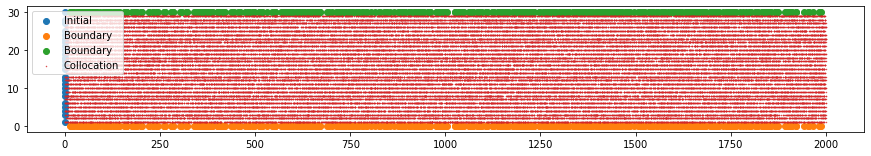

In [25]:
plt.figure(figsize = (15,15))
plt.gca().set_aspect(10)
plt.scatter(t_i, x_i, label = "Initial")
plt.scatter(t_b, x_l, label = "Boundary")
plt.scatter(t_b, x_r, label = "Boundary")
plt.scatter(t_c, x_c, label = "Collocation", s = 0.2)
plt.legend()

We have our data and we now convert it to torch tensors and concatenate the respective $x,t$ tensors to feed to the neural network.

In [26]:
x_torch_i = torch.from_numpy(x_i).float()
t_torch_i = torch.from_numpy(t_i).float()
h_torch_i = torch.from_numpy(h_i).float()

x_torch_l = torch.from_numpy(x_l).float()
x_torch_r = torch.from_numpy(x_r).float()
t_torch_b = torch.from_numpy(t_b).float()
h_torch_l = torch.from_numpy(h_l).float()
h_torch_r = torch.from_numpy(h_r).float()

x_torch_c = torch.from_numpy(x_c).float()
t_torch_c = torch.from_numpy(t_c).float()
h_torch_c = torch.from_numpy(h_c).float()

x_torch_d = torch.from_numpy(x_d).float()
t_torch_d = torch.from_numpy(t_d).float()
h_torch_d = torch.from_numpy(h_d).float()

### Concatenate the respective x and t tensors 
X_i = torch.cat((x_torch_i, t_torch_i), 1)

X_l = torch.cat((x_torch_l, t_torch_b), 1)
X_r = torch.cat((x_torch_r, t_torch_b), 1)

X_c = torch.cat((x_torch_c, t_torch_c), 1)

X_d = torch.cat((x_torch_d, t_torch_d), 1)

Now we transfer this data, as well as an object of the *physics_informed_NN* class to the TPUs to run our computatations.

In [27]:
PINN = physics_informed_NN()
PINN.to(device)

X_i = X_i.to(device)
H_small_i = h_torch_i.to(device)

X_l = X_l.to(device)
H_small_l = h_torch_l.to(device)
X_r = X_r.to(device)
H_small_r = h_torch_r.to(device)

X_c = X_c.to(device)
H_small_c = h_torch_c.to(device)

X_d = X_d.to(device)
H_small_d = h_torch_d.to(device)

Using the loss function defined above, we run backpropagation on the neural network using the *Adam* optimizer. Our criterion is obviously MSE Loss and we also have a scheduler to control the learning rate.

In [28]:
optimizer = torch.optim.Adam(PINN.parameters(), lr=0.001)
criterion = nn.MSELoss()
my_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=200, gamma=0.9)
# my_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer)
#C = torch.tensor(0., requires_grad = True)

# M = torch.zeros((Nc), requires_grad = True, dtype = float, device = device)
A = torch.tensor(0., requires_grad = True, device = device)
B = torch.tensor(0., requires_grad = True, device = device)
optimizer.add_param_group({'params': A})
optimizer.add_param_group({'params': B})


The loop below is actually training the network. The epochs just mean the number of times the whole dataset is exposed to the neural network. Note that running on TPUs requires slightly different commands for optimizer steps.

In [29]:
statistics = []
for epochs in range(15000):

    X_c_clone = X_c.clone()
    X_c_clone.requires_grad = True
    h_pred = PINN(X_c_clone)

    b = 1.0 - 0.01*X_c_clone[:,0]
    b = torch.reshape(b, (-1,1))
    # M = 0.004-0.0002*X_c_clone[:,0]

    H_pred = torch.sub(h_pred, b)
    gradients_h = torch.autograd.grad(torch.sum(h_pred), X_c_clone, create_graph=True)
    h_x = gradients_h[0][:,0]
    h_t = gradients_h[0][:,1]
    hessians_h = torch.autograd.grad(torch.sum(h_x), X_c_clone, create_graph=True)
    h_xx = hessians_h[0][:,0]

    gradients_H = torch.autograd.grad(torch.sum(H_pred), X_c_clone, create_graph=True)
    H_x = gradients_H[0][:,0]

    flux = - C_true * torch.pow(torch.squeeze(H_pred), 5) * torch.pow(torch.abs(h_x), 2) * h_x
    gradients_flux = torch.autograd.grad(torch.sum(flux), X_c_clone, create_graph=True)
    flux_x = - gradients_flux[0][:,0]
    M = B + A*X_c_clone[:, 0]
    pde_rhs = M + flux_x
    collocation_mse = criterion(h_t, pde_rhs)
    initial_mse = criterion(PINN(X_i), H_small_i)
    left_mse = criterion(PINN(X_l), H_small_l)
    right_mse = criterion(PINN(X_r), H_small_r)
    data_mse = criterion(PINN(X_d), H_small_d)

    loss = right_mse + left_mse + initial_mse + 75*collocation_mse + 25*data_mse

    optimizer.zero_grad()  
    loss.backward()       
    xm.optimizer_step(optimizer)
    xm.mark_step()
    my_lr_scheduler.step()

    if (epochs % 100 == 0):
        statistics.append([epochs, A.detach().clone().cpu().data.numpy(), B.detach().clone().cpu().data.numpy(), loss.cpu().data.numpy(), left_mse.cpu().data.numpy(), right_mse.cpu().data.numpy(), initial_mse.cpu().data.numpy(), collocation_mse.cpu().data.numpy(), data_mse.cpu().data.numpy()])
        print (f'epoch = {epochs}, lr = {my_lr_scheduler.get_last_lr()},  loss = {loss}, A = {A}, B = {B}, l_loss = {left_mse}, r_loss = {right_mse}, i_mse = {initial_mse}, c_mse = {collocation_mse}, d_mse = {data_mse}')

epoch = 0, lr = [0.001, 0.001, 0.001],  loss = 42.13141632080078, A = -0.0009999998146668077, B = -0.0009999985340982676, l_loss = 1.0013563632965088, r_loss = 0.4799574315547943, i_mse = 0.6129605174064636, c_mse = 4.876989351032535e-06, d_mse = 1.6014710664749146
epoch = 100, lr = [0.001, 0.001, 0.001],  loss = 0.587949275970459, A = -3.511835166136734e-05, B = 0.0006607323884963989, l_loss = 0.10111872851848602, r_loss = 0.1388339251279831, i_mse = 0.0007518562488257885, c_mse = 8.71468182594981e-06, d_mse = 0.013863647356629372
epoch = 200, lr = [0.0009000000000000001, 0.0009000000000000001, 0.0009000000000000001],  loss = 0.33781448006629944, A = -1.3006954759475775e-05, B = 0.0005499432445503771, l_loss = 0.03142967447638512, r_loss = 0.06492366641759872, i_mse = 0.0020824025850743055, c_mse = 2.695993498491589e-05, d_mse = 0.009494269266724586
epoch = 300, lr = [0.0009000000000000001, 0.0009000000000000001, 0.0009000000000000001],  loss = 0.18256539106369019, A = -5.237437289906

We now check the performance of our model on the entire grid.

In [30]:
## Grid x,t together for test dataa
test_data = np.array(np.meshgrid(x, t))
test_data = np.moveaxis(test_data, [0, 1, 2], [-1,0,1])
input_test_data = torch.from_numpy(np.reshape(test_data, (-1, 2)))
input_test_data = input_test_data.to(device).float()

### Actual solution on the entire grid
h_test_data = torch.from_numpy(np.reshape(h_true, (-1,1)))

### Predict on the entire grid
with torch.no_grad():
##### FOR TPUs ######
    h_predicted = PINN(input_test_data).cpu().data.numpy()

##### FOR CUDA/GPUs ######
#   if torch.cuda.is_available():
#     h_predicted = PINN(input_test_data).cpu().data.numpy()
#   else:
#     h_predicted = PINN(input_test_data).data.numpy()


Now, we plot our predicted solution. Since *u_predicted* is a single vector, we need to reshaoe it into the shape of the grid in order to plot the filled contours. 

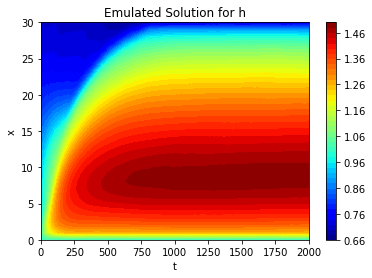

In [31]:
# norm = mcolors.TwoSlopeNorm(vmin=h_predicted.min(), vmax = h_predicted.max(), vcenter=0)
h_pred_final = np.reshape(h_predicted, (h_true.shape[1], h_true.shape[0])).T

plt.contourf(np.squeeze(t),np.squeeze(x),h_pred_final, cmap = 'jet', levels = 50)
plt.xlabel('t')
plt.ylabel('x')
plt.title('Emulated Solution for h')
plt.colorbar()
plt.show()

In [32]:
A, B

(tensor(-0.0002, device='xla:1', requires_grad=True),
 tensor(0.0041, device='xla:1', requires_grad=True))

Text(0.5, 0, 'Epochs')

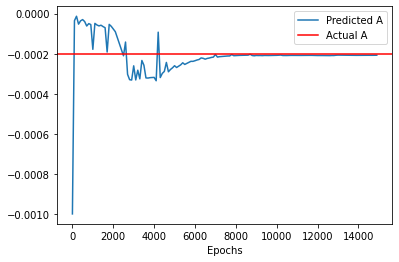

In [33]:
plt.plot([statistic[0] for statistic in statistics], [statistic[1] for statistic in statistics], label = 'Predicted A')

plt.axhline(-0.0002, label = 'Actual A', color = 'red')
plt.legend()
plt.xlabel('Epochs')


Text(0.5, 0, 'Epochs')

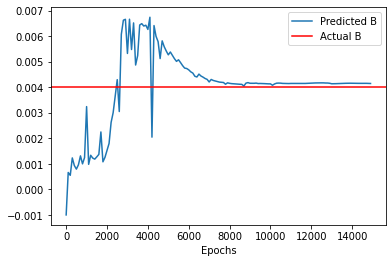

In [34]:
plt.plot([statistic[0] for statistic in statistics], [statistic[2] for statistic in statistics], label = 'Predicted B')

plt.axhline(0.004, label = 'Actual B', color = 'red')
plt.legend()
plt.xlabel('Epochs')

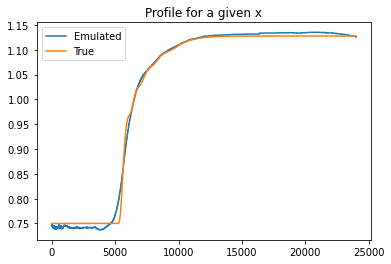

In [35]:
# plt.plot(h_pred_final)
plt.plot(h_pred_final[25,:], label = 'Emulated')
plt.plot(h_true[25,:], label = 'True')
plt.title('Profile for a given x')
plt.legend()

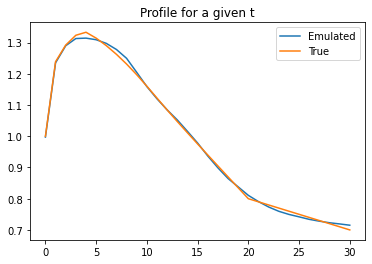

In [36]:
plt.plot(h_pred_final[:,1500], label = 'Emulated')
plt.plot(h_true[:,1500], label = 'True')
plt.title('Profile for a given t')
plt.legend()

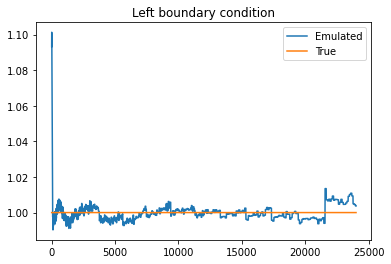

In [37]:
plt.plot(h_pred_final[0,:], label = 'Emulated')
plt.plot(h_true[0,:], label = 'True')
plt.title('Left boundary condition')
plt.legend()

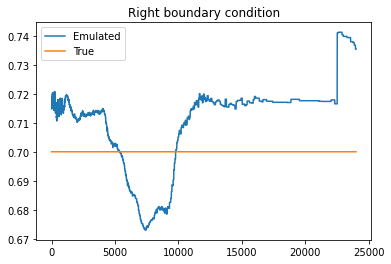

In [38]:
plt.plot(h_pred_final[-1,:], label = 'Emulated')
plt.plot(h_true[-1,:], label = 'True')
plt.title('Right boundary condition')
plt.legend()

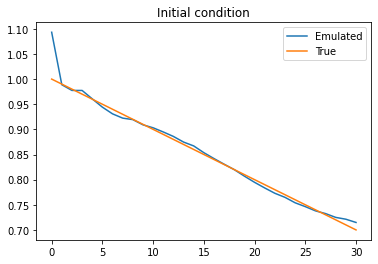

In [39]:
plt.plot(h_pred_final[:,0], label = 'Emulated')
plt.plot(h_true[:,0], label = 'True')
plt.title('Initial condition')
plt.legend()

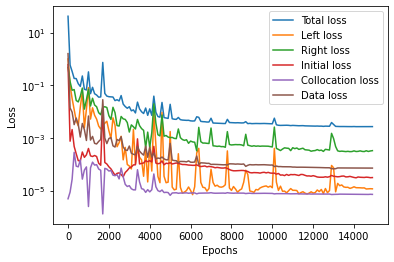

In [40]:
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot([statistic[0] for statistic in statistics], [statistic[3] for statistic in statistics], label = 'Total loss')
plt.plot([statistic[0] for statistic in statistics], [statistic[4] for statistic in statistics], label = 'Left loss')
plt.plot([statistic[0] for statistic in statistics], [statistic[5] for statistic in statistics], label = 'Right loss')
plt.plot([statistic[0] for statistic in statistics], [statistic[6] for statistic in statistics], label = 'Initial loss')
plt.plot([statistic[0] for statistic in statistics], [statistic[7] for statistic in statistics], label = 'Collocation loss')
plt.plot([statistic[0] for statistic in statistics], [statistic[8] for statistic in statistics], label = 'Data loss')
plt.legend()